In [1]:
from keras import Model
from keras.layers import InputLayer, Conv2D, Dropout, BatchNormalization
from keras.layers import Concatenate, Conv2DTranspose, LeakyReLU, ReLU
from keras.layers import Multiply, Subtract, Add

def gen_separate_unet(input_shape=(512, 128, 1), encode=5, num_separ=2) : 
    input_layer = InputLayer(input_shape=input_shape).input

    separation_list = []
    for _ in range(num_separ) : 
        last_layer = input_layer
        concate_list = []
        filter_num = 16 * input_shape[2]                # set initial number of filters as 16
        
        for _ in range(encode) : 
            conv_encoder = Conv2D(filters=filter_num, kernel_size=5, strides=2, padding="same")(last_layer)
            batch_norm = BatchNormalization()(conv_encoder)
            activ_layer = LeakyReLU(alpha=0.2)(batch_norm)
            
            concate_list.insert(0, conv_encoder)
            last_layer = activ_layer
            filter_num *= 2
        
        conv_layer = Conv2D(filters=filter_num, kernel_size=5, strides=2, padding="same")(last_layer)
        activ_layer = LeakyReLU(alpha=0.2)(conv_layer)
        last_layer = activ_layer

        count = 1
        for concate_layer in concate_list : 
            filter_num /= 2

            conv_trans = Conv2DTranspose(filters=filter_num, kernel_size=5, strides=2, padding="same")(last_layer)
            merge_layer = Concatenate(axis=3)([conv_trans, concate_layer])
            conv_decoder = Conv2D(filters=filter_num, kernel_size=5, strides=1, padding="same")(merge_layer)
            batch_norm = BatchNormalization()(conv_decoder)
            activ_layer = ReLU()(batch_norm)

            if count <= 3 : 
                last_layer = Dropout(rate=0.5)(activ_layer)
            
            else : 
                last_layer = activ_layer
            
            count += 1

        conv_layer = Conv2DTranspose(filters=8 * input_shape[2], kernel_size=5, strides=2, padding="same")(last_layer)
        conv_layer = Conv2DTranspose(filters=input_shape[2], kernel_size=3, strides=1, padding="same", activation="sigmoid")(conv_layer)
        
        separation_list.append(conv_layer)

    output_layer_list = []
    subtract_list = []
    count = 0
    for layer in separation_list : 
        if not count : 
            vocal_separation_layer = layer
        else : 
            output_layer = Multiply(name="separation_{}".format(count))([input_layer, layer])
            output_layer_list.append(output_layer)
            subtract_list.append(layer)
        count += 1
    
    for iteration, inst_layer in enumerate(subtract_list) : 
        vocal_separation_layer = Subtract(name="sub_{}".format(iteration + 1))([vocal_separation_layer, inst_layer])
    
    vocal_separation_layer = Multiply(name="vocal_separation")([input_layer, vocal_separation_layer])
    output_layer_list.insert(0, vocal_separation_layer)

    return Model(inputs=[input_layer], outputs=output_layer_list)



------------------------- Original track -------------------------
Voice
Length : 133056
Sample rate : 11000
L / R : 12.10 sec


Music
Length : 133056
Sample rate : 11000
L / R : 12.10 sec


Merge


(960, 520) (960, 520) (960, 520)
Quotient : 8
(960, 384) (960, 384) (960, 384)


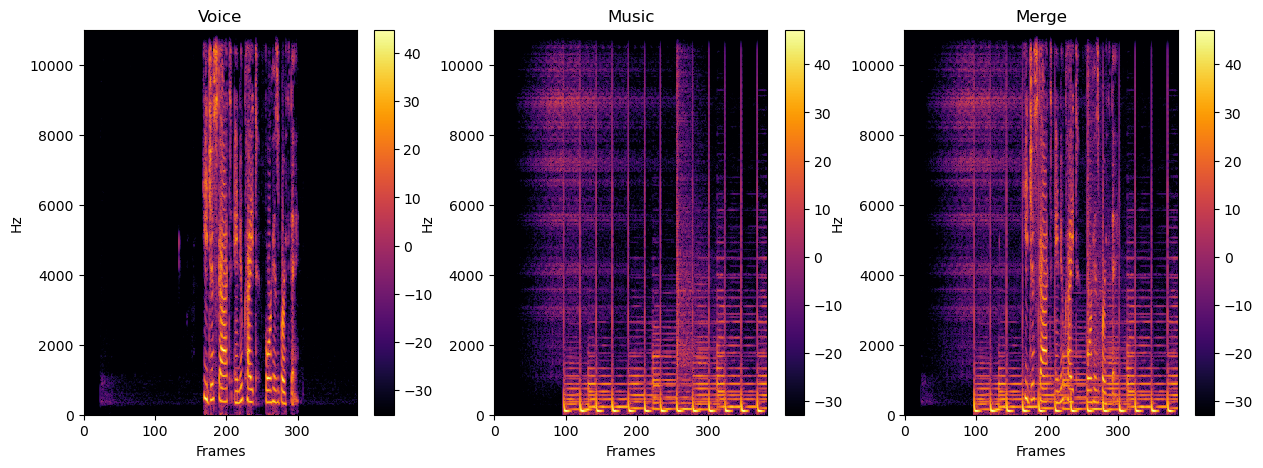

------------------------- Edited track -------------------------
Voice


Music


Merge


In [3]:
import librosa, os
from IPython.display import Audio

Data_path = os.path.pardir
Data_path += "/Data/kaggle_data/common-voice/"
test_data_path = Data_path + "cv-valid-train/cv-valid-train/" + "sample-174437" + ".mp3"

sample_rate = 11000

voice_source, sample_rate = librosa.load(test_data_path, sr=sample_rate, mono=True)

print("------------------------- Original track -------------------------")

print("Voice")
print("Length : {}".format(len(voice_source)))
print("Sample rate : {}".format(sample_rate))
print("L / R : {:.2f} sec".format(len(voice_source) / sample_rate))
display(Audio(voice_source, rate=sample_rate))

music_data_path = "../Data/sample/Jonas Blue - Fast Car ft. Dakota (Official Video).mp3"

music_source, sample_rate = librosa.load(music_data_path, mono=True, duration=(len(voice_source) / sample_rate), sr=sample_rate)

print("Music")
print("Length : {}".format(len(music_source)))
print("Sample rate : {}".format(sample_rate))
print("L / R : {:.2f} sec".format(len(music_source) / sample_rate))

display(Audio(music_source, rate=sample_rate))

print("Merge")
merge_source = voice_source + music_source

display(Audio(merge_source, rate=sample_rate))

import numpy as np
import matplotlib.pyplot as plt

# n_fft = 2 * (64 * input_shape - 1)        /       example - 1022, 1278, 1918, 2558, 3198
n_fft = 1918
win_length = int(1024)
D_voice_raw = librosa.stft(voice_source, n_fft=n_fft, win_length=win_length)
D_music_raw = librosa.stft(music_source, n_fft=n_fft, win_length=win_length)
D_merge_raw = librosa.stft(merge_source, n_fft=n_fft, win_length=win_length)

print(D_voice_raw.shape, D_music_raw.shape, D_merge_raw.shape)

Quotient = len(D_voice_raw[0,:]) // 64
print("Quotient : {}".format(Quotient))

round_off = int((Quotient - 2) * 64)
D_voice_raw = D_voice_raw[:,:round_off]
D_music_raw = D_music_raw[:,:round_off]
D_merge_raw = D_merge_raw[:,:round_off]
print(D_voice_raw.shape, D_music_raw.shape, D_merge_raw.shape)      # input shape must be multiple of 64

# try : 
#     del fig, axes
# finally : 
#     pass

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for ax, D, title in zip(axes, [np.abs(D_voice_raw), np.abs(D_music_raw), np.abs(D_merge_raw)], ["Voice", "Music", "Merge"]) : 
    S_db = librosa.amplitude_to_db(D)
    cb = librosa.display.specshow(S_db, x_axis="frames", y_axis="fft", sr=sample_rate * 2, ax=ax, cmap="inferno")
    ax.set_title(title)
    plt.colorbar(cb)
plt.show()

print("------------------------- Edited track -------------------------")
print("Voice")
display(Audio(data=librosa.istft(D_voice_raw, n_fft=n_fft, win_length=win_length), rate=sample_rate))
print("Music")
display(Audio(data=librosa.istft(D_music_raw, n_fft=n_fft, win_length=win_length), rate=sample_rate))
print("Merge")
display(Audio(data=librosa.istft(D_merge_raw, n_fft=n_fft, win_length=win_length), rate=sample_rate))


In [4]:
print(D_voice_raw.shape, D_music_raw.shape, D_merge_raw.shape)
print(n_fft)

(960, 384) (960, 384) (960, 384)
1918


In [5]:
import numpy as np
def complex_to_polar(array) : 
    r = np.abs(array)
    angle = np.angle(array)
    
    result_array = np.zeros(shape=(*array.shape, 2), dtype=array[...,0].real.dtype)
    result_array[..., 0] = r
    result_array[..., 1] = angle
    
    return result_array

polar_voice = complex_to_polar(D_voice_raw)
polar_music = complex_to_polar(D_music_raw)
polar_merge = complex_to_polar(D_merge_raw)

print(polar_voice.shape, polar_music.shape, polar_merge.shape)

def polar_to_complex(array) : 
    from numpy import cos, sin
    
    r = array[..., 0]
    theta = array[..., 1]

    real_part = r * cos(theta)
    imag_part = r * sin(theta)
    
    complex_array = real_part + imag_part * 1j

    return complex_array

(960, 384, 2) (960, 384, 2) (960, 384, 2)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 960, 384, 2  0           []                               Y          
                                )]                                                                           
                                                                                                             
 conv2d (Conv2D)                (None, 480, 192, 32  1632        ['input_1[0][0]']                Y          
                                )                                                                            
                                                                                                             
 conv2d_11 (Conv2D)     

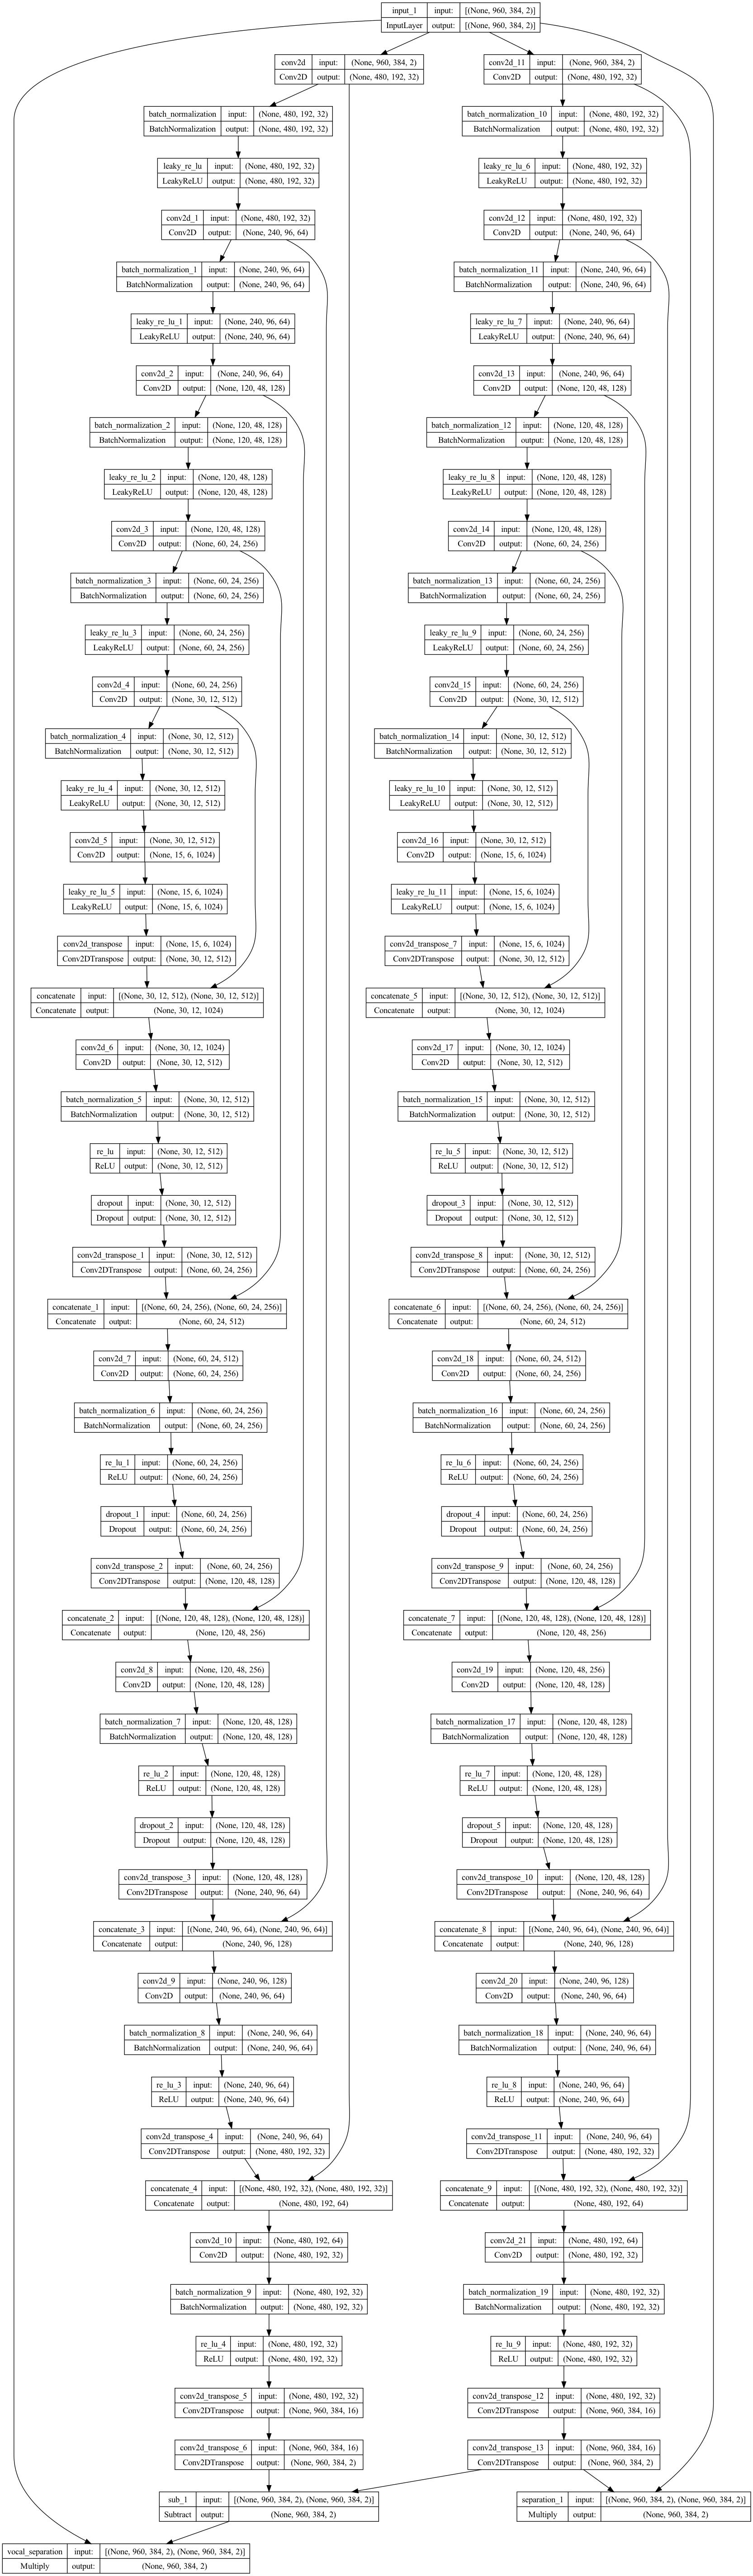

In [6]:
from keras.utils import plot_model
from keras.backend import clear_session

clear_session()
test_model = gen_separate_unet(input_shape=polar_merge.shape, encode=5, num_separ=2)
test_model.summary(show_trainable=True)
plot_model(test_model, show_shapes=True)

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

patience = 50
early_stop = EarlyStopping(monitor="loss", patience=patience, verbose=True, restore_best_weights=True, min_delta=0.01)
check_point = ModelCheckpoint(filepath="./soft_U_Net_checkpoint/", monitor="loss", verbose=True, save_best_only=True, save_weights_only=True)
callbacks = [early_stop, check_point]
callbacks = [early_stop]

print("Total params : {:,}".format(test_model.count_params()))

Total params : 104,808,484


In [ ]:
test_model.compile(optimizer="adam", loss="mae", metrics=["mse", "mae"])
history = test_model.fit(
    x=polar_merge.reshape((1, *polar_merge.shape)), y=[
        polar_voice.reshape((1, *polar_voice.shape)), polar_music.reshape((1, *polar_music.shape)), 
        # polar_voice.reshape((1, *polar_voice.shape)), polar_music.reshape((1, *polar_music.shape))
    ],
    batch_size=1, epochs=patience * 10, verbose=2, callbacks=callbacks
)
test_model.save(filepath="./U_Net_checkpoint/checkpoint.h5")

In [12]:
for keys in sorted(history.history.keys(), key=lambda x : x[0]) : 
    print(keys)
# multiply : voice
# subtract : music
# previous : AVG_loss 0.996

loss
separation_1_loss
separation_1_mse
separation_1_mae
vocal_separation_loss
vocal_separation_mse
vocal_separation_mae


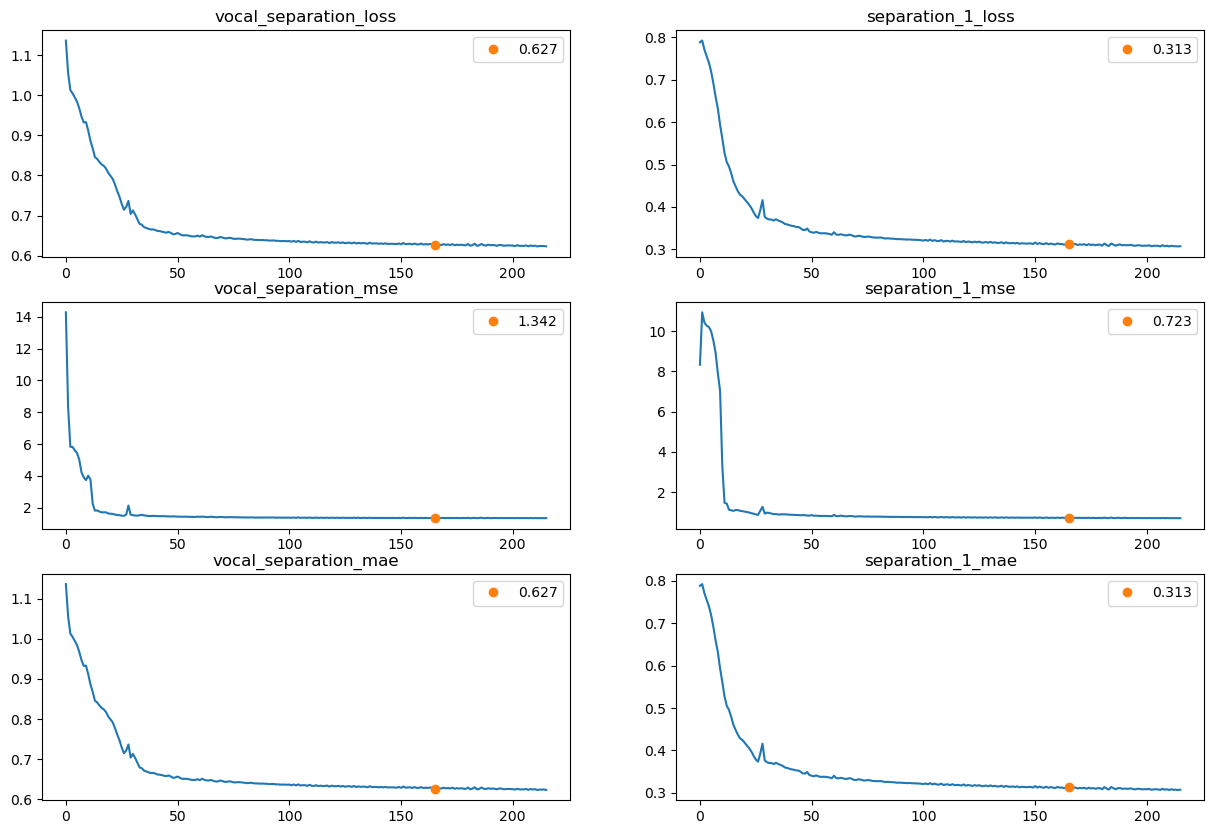

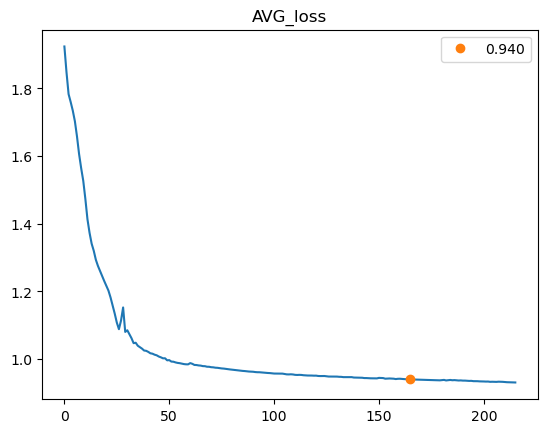

In [13]:
import matplotlib.pyplot as plt

epoch = history.epoch
best_epoch = epoch[-1] - patience

separation_num = int((len(history.history.keys()) - 1) / 3)

fig, axes = plt.subplots(nrows=3, ncols=separation_num, figsize=(15, 10))

loss = history.history["loss"]

for index, key in zip([0, 1, 2], ["loss", "mse", "mae"]) : 
    ax_row = axes[index]

    key_list = ["separation_{}_{}".format(i + 1, key) for i in range(separation_num)]
    key_list.insert(0, "vocal_separation_{}".format(key))

    for ax, key in zip(ax_row, key_list) : 
        ax.plot(epoch, history.history[key])
        ax.plot(best_epoch, history.history[key][best_epoch], 'o', label="{:.3f}".format(history.history[key][best_epoch]))
        ax.set_title(key)
        ax.legend()

plt.show()

plt.plot(epoch, loss)
plt.plot(best_epoch, loss[best_epoch], 'o', label="{:.3f}".format(loss[best_epoch]))
plt.title("AVG_loss")
plt.legend()
plt.show()


In [14]:
# from keras.models import load_model
# test_model = load_model(filepath="./U_Net_checkpoint/checkpoint.h5")

pred_polar_list = test_model.predict(polar_merge.reshape((1, *polar_merge.shape)))

voice_pred_list = []
music_pred_list = []
count = 1
for pred_polar in pred_polar_list : 
    pred_polar = polar_to_complex(pred_polar)

    if count % 2 != 0 : 
        voice_pred_list.append(pred_polar.reshape((pred_polar.shape[1:3])))
    else : 
        music_pred_list.append(pred_polar.reshape((pred_polar.shape[1:3])))
    count += 1

print(voice_pred_list[0].shape)

1/1 [==============================] - 1s 514ms/step
(960, 384)


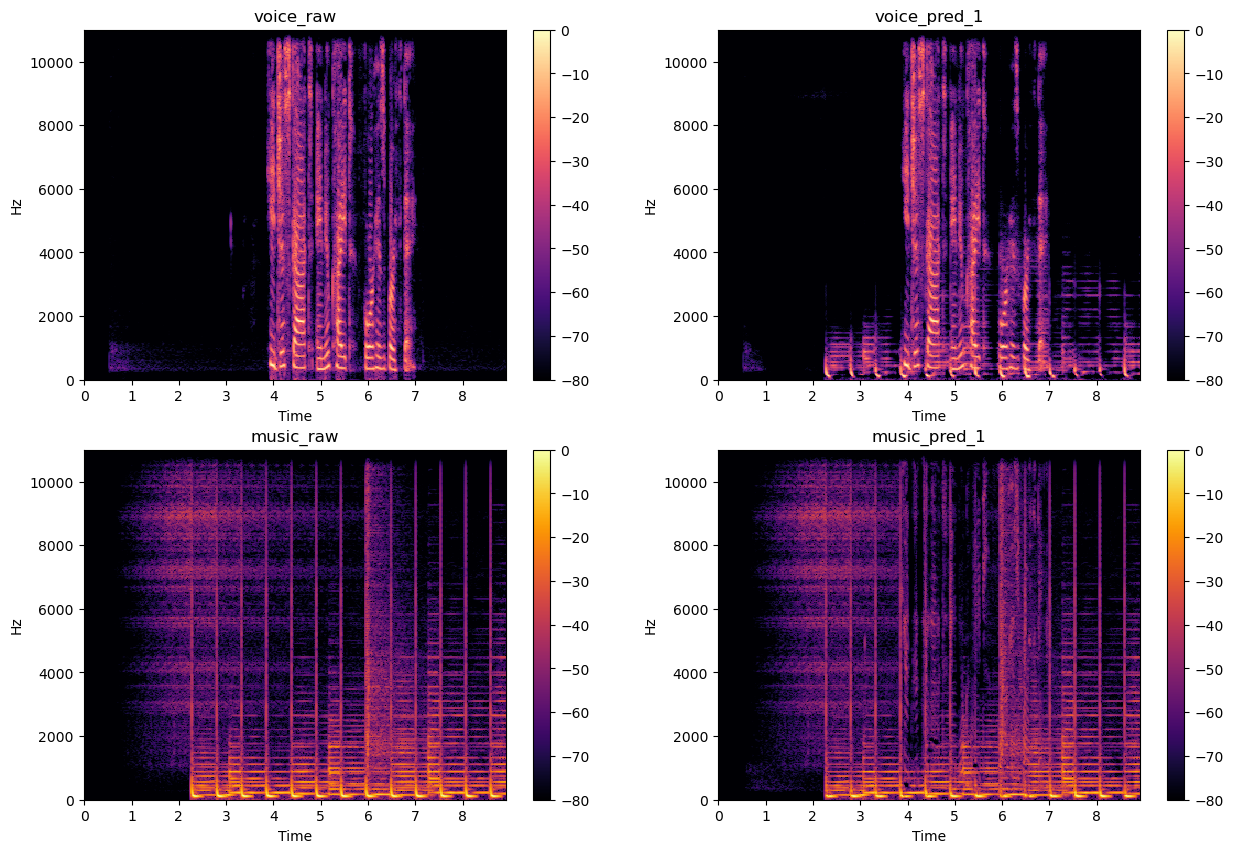

In [15]:
for i in range(len(voice_pred_list)) : 
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    for ax, data in zip(axes[0], [np.abs(D_voice_raw), np.abs(voice_pred_list[i])]) : 
        D_db = librosa.amplitude_to_db(data, ref=np.max)
        cb = librosa.display.specshow(D_db, x_axis="time", y_axis="fft", sr=sample_rate * 2, ax=ax)
        plt.colorbar(cb)

    D_music_temp = librosa.amplitude_to_db(np.abs(D_music_raw), ref=np.max)
    cb = librosa.display.specshow(D_music_temp, x_axis="time", y_axis="fft", sr=sample_rate * 2, ax=axes[1,0], cmap="inferno")
    plt.colorbar(cb)

    D_compare = librosa.amplitude_to_db(np.abs(music_pred_list[i]), ref=np.max)
    cb = librosa.display.specshow(D_compare, x_axis="time", y_axis="fft", sr=sample_rate * 2, ax=axes[1,1], cmap="inferno")
    plt.colorbar(cb)

    axes[0,0].set_title("voice_raw")
    axes[1,0].set_title("music_raw")
    axes[0,1].set_title("voice_pred_{}".format(i + 1))
    axes[1,1].set_title("music_pred_{}".format(i + 1))

    plt.show()

In [16]:
merge_inverse = librosa.istft(D_merge_raw, n_fft=n_fft, win_length=win_length)
voice_inverse = librosa.istft(D_voice_raw, n_fft=n_fft, win_length=win_length)

display(Audio(merge_inverse, rate=sample_rate))
display(Audio(voice_inverse, rate=sample_rate))

for i in range(len(voice_pred_list)) : 
    print("{}th output".format(i + 1))
    pred_voice = voice_pred_list[i]
    pred_music = music_pred_list[i]
    pred_inverse_voice = librosa.istft(pred_voice, n_fft=n_fft, win_length=win_length)
    pred_inverse_music = librosa.istft(pred_music, n_fft=n_fft, win_length=win_length)

    display(Audio(pred_inverse_voice, rate=sample_rate))
    display(Audio(pred_inverse_music, rate=sample_rate))

1th output
